# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">


## Gaussian PDF and Maximum Likelihood Estimation (MLE)

In [18]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}|
</style>
""")

## My own latex definitions
$\require{color}$

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}
font = {'family' : 'sans serif',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Unsupervised Learning and Clustering
- K-means
- Inverse Transform Sampling
- K-means++
- Applications of K-means for:
    - Color compression
    - Digits Classification
    - Brief hints on image pipeline classification as k-means as building block

# Today's lecture
## Unsupervised Learning
## Density Estimator
## Single Gaussian
## Maximum Likelihood Estimation (MLE)
## Intro to GMM (Gaussian Mixture Model)

# This lecture material is taken from
- [Cimi Book - Chapter 15](http://ciml.info/dl/v0_99/ciml-v0_99-ch15.pdf)
- [Bishop - Chapter 9.2](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
- [MLE Principle - D2L.ai](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle)
- [Stanford Kmeans](https://www.youtube.com/watch?v=LmpkKwsyQj4)
- [Stanford Kmeans](http://cs229.stanford.edu/syllabus-summer2020.html)
- [Illustrations](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch11/ch11.ipynb)
- [Code](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

# K-means as a loss minimization problem

Similarly as PCA, we can define a **loss or cost function** that can better formalize the K-means algorithm.

$$ \mathcal{L}(\mbf{\mu},y;\mbf{D}) = \sum_{i=1}^N \left| \left| \mbf{x}_i - \mbf{\mu}_{y_i} \right|\right|_2^2 $$

- Criterion for separating samples in $K$ groups of equal variance, minimizing the "inertia" or "within-cluster sum-of-squares" (within cluster variance).
- Sum of squared distances from any data point to its assigned center

# Homework 2a

Given the scalar function:

$$ \mathcal{L}(\mbf{\mu};\mbf{D}) = \sum_{i=1}^N \left( {x}_i - {\mu} \right)^2 $$

Write a proof sketch that ${\mu}$ as the **average** of $\mbf{D}\doteq\{{x}_i\}_{i=1}^N$ is a critical point of the function. (It is also a global minimum)

# Homework 2b

Given the  function vector to scalar function, where the assignments $\bar{y}$ are given somehow (they cannot "move"):

$$ \mathcal{L}(\mbf{\mu},\bar{y};\mbf{D}) = \sum_{i=1}^N \left| \left| \mbf{x}_i - \boldsymbol{\mu}_{\bar{y}_i} \right|\right|_2^2 $$

Write a proof sketch that $\boldsymbol{\mu}$ as the **average** of the vectors $\mbf{D}\doteq\{\mbf{x}_i\}_{i=1}^N$ is a critical point of the function.  (It is also a global minimum)

_Hint: set the derivative/gradient of mu to zero and solve; for 2b) pay attention on how the L2 norm is defined_

# Unsupervised Learning

**Objective and Motivation:** The goal of unsupervised learning is to find **hidden patterns** in unlabeled data. 

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}


- Unlike in supervised learning, any data points is not paired with a label.

- As you can see the unsupervised learning problem is ill-posed (which hidden patterns?) and in principle more difficult than supervised learning.

- Unsupervised learning can be thought of as "finding structure" in the data.

# Discrete Random Variable

In [20]:
dist =  np.array([1.18518298, 1.30917493, 1.10973212, 2.24523519, 1.01625606])
pmf = dist/dist.sum()

# Inverse Transform Sampling

- Step 1. Transform the closed set $D$ of distances into a distribution (probability mass function - pdf) as

$$p(d^{\prime})= \frac{d^{\prime}}{\sum_{d \in D} d}  $$

`dist = {{dist = np.array([1.18518298, 1.30917493, 1.10973212, 2.24523519, 1.01625606]);print(dist)}}`

to
{{pmf = dist/dist.sum()}}

`pmf = {{print(pmf)}}` simply with

```pyhton
pmf = dist/dist.sum()
```

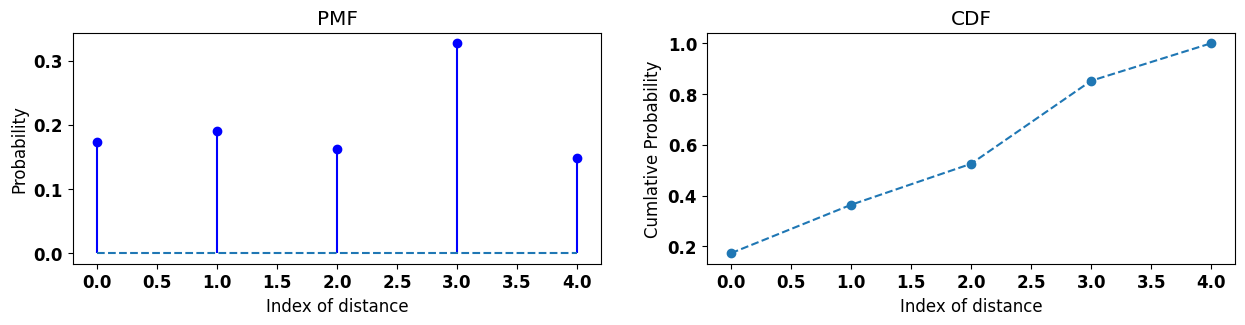

In [21]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(15)
# PDF
axs[0].stem(pmf, linefmt='b-', markerfmt='bo', basefmt='--')
axs[0].set_title('PMF')
axs[0].set_xlabel('Index of distance')
axs[0].set_ylabel('Probability')
axs[0].set_aspect('auto')
# CUMSUM
axs[1].plot(pmf.cumsum(), 'o--')
axs[1].set_title('CDF')
axs[1].set_xlabel('Index of distance')
axs[1].set_ylabel('Cumlative Probability')
axs[1].set_aspect('auto')
plt.show()

# Inverse Transform Sampling in Action

<br/><center>
<img width="40%" src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Inverse_Transform_Sampling_Example.gif" /></center>

# Gaussian (Normal) Distribution

- $\mu$ is the mean
- $\Sigma$ is the covariance matrix
- $k$ is the dimension of the space where $x$  takes values
$$
   f(x) = \frac{1}{\sqrt{(2 \pi)^k \colorbox{yellow}{$\det \Sigma$}}}
               \exp\left( -\frac{1}{2} \colorbox{yellow}{$(x - \mu)^T \Sigma^{-1} (x - \mu)$} \right),
$$

# Univariate Gaussian (1-D Gaussian)


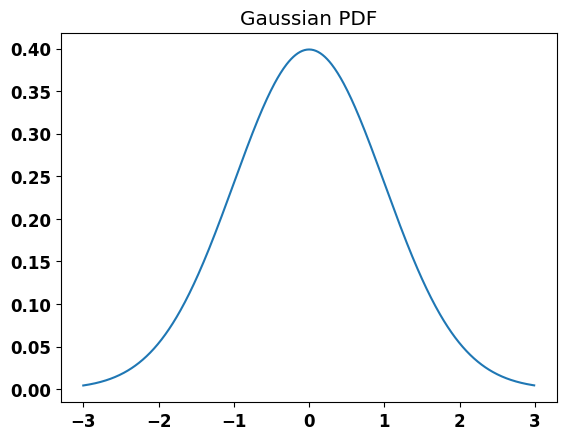

In [22]:
# Univariate Gaussian (1-D Gaussian)
mu, sigma = 0, 1
x = np.arange(-3, 3, 0.01)
p = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2)) 
_ = plt.plot(x, p);
_ = plt.title('Gaussian PDF')

# Cumulative Density Function

<img src="https://d2l.ai/_images/output_distributions_c7d568_219_0.svg" />

<img src="https://d2l.ai/_images/output_integral-calculus_06e2a4_15_0.svg" />

# Multivariate Gaussian (N-D Gaussian)


- $\mu$ is the mean
- $\Sigma$ is the covariance matrix
- $k$ is the dimension of the space where $x$  takes values **(k=2 in this case)**

$$
   f(x) = \frac{1}{\sqrt{(2 \pi)^k \colorbox{yellow}{$\det \Sigma$}}}
               \exp\left( -\frac{1}{2} \colorbox{yellow}{$ (x - \mu)^T \Sigma^{-1} (x - \mu)$} \right),
$$

In [23]:
from scipy.stats import multivariate_normal
mu = [0, 0]
Sigma = [[2, 0.0],
         [0.0, 1]]
F = multivariate_normal(mu, Sigma )

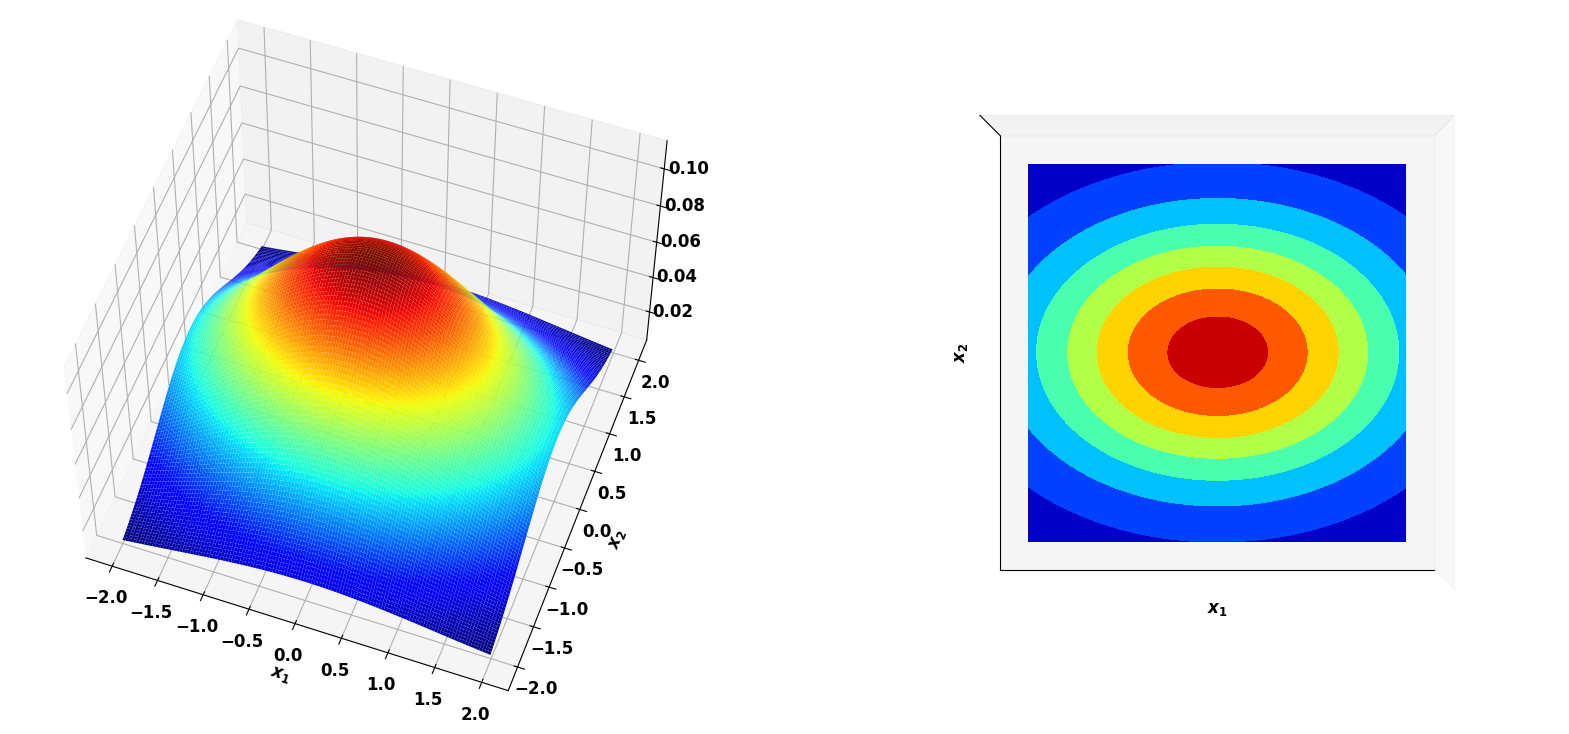

In [24]:
from scipy.stats import multivariate_normal
X, Y = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((X, Y))
Z = F.pdf(pos)

# plot using subplots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                 cmap='jet')
ax1.view_init(55, -70)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet')
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

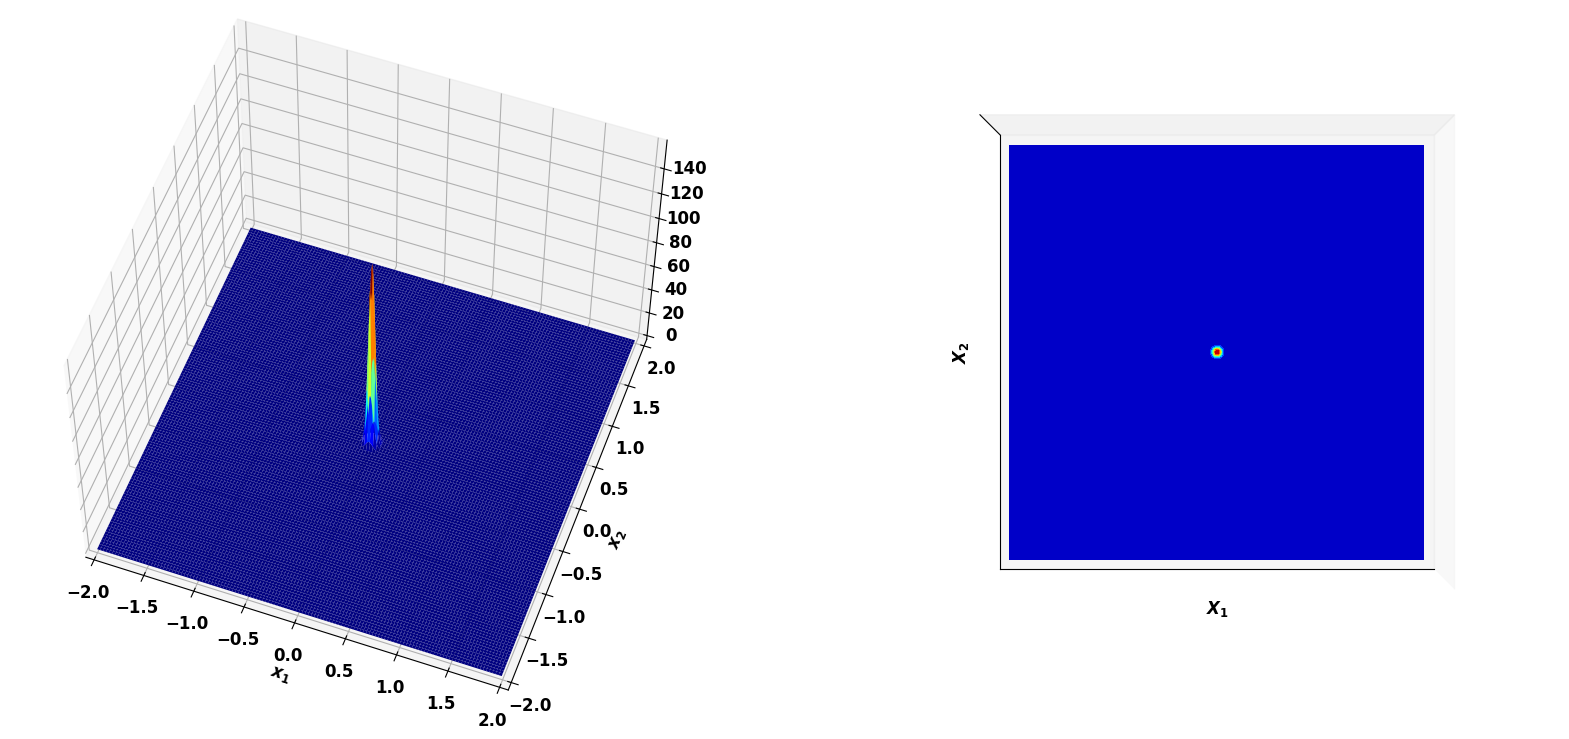

In [25]:
from scipy.stats import multivariate_normal
step = 0.01
X, Y = np.mgrid[-2:2:step, -2:2:step]
pos = np.dstack((X, Y))
##############################
### Gaussian PDF definition
Sigma = [[.001, 0.0],
         [0.0, .001]]
mu = [0, 0]
F = multivariate_normal(mu, Sigma )
##############################
Z = F.pdf(pos)

# plot using subplots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                 cmap='jet')
ax1.view_init(55, -70)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.set_xlim3d(-2,2)
ax1.set_ylim3d(-2,2)
#ax1.set_zlim3d(0,0.15)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet')
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$X_1$')
ax2.set_ylabel(r'$X_2$')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)


plt.show()

# The Mahalanobis distance

The Mahalanobis distance of a point $\mbf{x}$ from a multivariate Gaussian $\mathcal{N}(\mbf{\mu},\mbf{\Sigma})$

$$ 
D_M(\vec{x}) = \sqrt{(\mbf{x} - \mbf{\mu})^\mathsf{T} \mathbf{\Sigma}^{-1} (\mbf{x} - \mbf{\mu})}
$$

- It is a multi-dimensional generalization of the idea of measuring **how many standard deviations** away $\mbf{x}$ is from the mean of $\mathcal{N}(\mbf{\mu},\mbf{\Sigma})$
- This distance is zero for $\mbf{x}$ at $\mbf{\mu}$ and grows as $\mbf{x}$ moves away from the mean along each principal component axis. 

- If each of these axes are re-scaled to have unit variance, then the Mahalanobis distance corresponds to **standard Euclidean** distance in the transformed space. The Mahalanobis distance is thus unitless, scale-invariant, and takes into account the correlations of the data set.

# Joint, Marginal, Conditional and Bayes Theorem

### Joint
- The distribution above can be seen as a **joint distribution $p(X,Y)$** of two random variables $X$ and $Y$
- It defines the density for two variables that co-occur together.

### Joint = Marginal $\times$ Conditional
$$\underbrace{p(X,Y)}_{\text{joint}} = \underbrace{p(X)}_{\text{marginal}} \underbrace{p(Y|X)}_{\text{cond.}}$$
Which is also equal to:
$$\underbrace{p(X,Y)}_{\text{joint}} = \underbrace{p(Y)}_{\text{marginal}} \underbrace{p(X|Y)}_{\text{cond.}}$$

### Bayes Theorem
$$ p(X,Y) = p(X)p(Y|X) =  p(Y)p(X|Y)$$

$$ p(Y|X) =  \frac{p(Y)p(X|Y)}{p(X)} \quad p(X) \text{  non zero} $$ 

### Bayes Theorem (other direction)
$$ p(X,Y) = p(X)p(Y|X) =  p(Y)p(X|Y)$$

$$ p(X|Y) =  \frac{p(X)p(Y|X)}{p(Y)} \quad p(Y) \text{  non zero} $$ 

You can also write the denominator more explicitly by expanding the marginal distribution (discrete case).

$$ p(Y|X) =  \frac{p(Y)p(X|Y)}{p(X)} = \frac{p(Y)p(X|Y)}{\sum_{Y^{\prime}}p(Y^{\prime})p(X|Y^{\prime})} $$

# Independent Random Variables

The joint probability simply becomes the product fo the marginals.

$$ p(X,Y) = p(X)p(Y|X) = p(X)p(Y) \text{  because   } p(Y) = p(Y|X)$$

when they $X \perp Y $

# Terminology for Statistics

<img width="70%" src="figs/terminology_a.png" />

# Terminology for Machine Learning

<img width="70%" src="figs/terminology_b.png" />

# Problem: Given data, learn the parameters

**Assumptions**
1. We have a set of observations or training data $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$ in d-dimensional space (for now the dimensionality is not important).
2. We also assume that the generation process of the data is governed by single Gaussian $\mu,\Sigma$. 
    - We do not know the values for this parameters $\mu,\Sigma$.
    - We wish to find them.
3. **Important assumption**: Data points that are drawn *independently from the same distribution* are said to be  *independent and identically distributed* (**i.i.d**). 

$$  X=\{\mbf{x}_1,\ldots,\mbf{x}_N \} \rightarrow  \mu,\Sigma $$

# The Maximum Likelihood Principle

This has a Bayesian interpretation which can be helpful to think about.  Suppose that we have a model with parameters $\boldsymbol{\theta}\doteq\mu,\Sigma$ and a collection of data examples $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$. 

If we want to find the **most likely value for the parameters of our model, given the data**, that means we want to find

$$\mathop{\mathrm{argmax}}_ {\boldsymbol{\theta}} P(\boldsymbol{\theta}\mid X).$$

By Bayes' rule, this is the same thing as

$$
\mathop{\mathrm{argmax}}_ {\boldsymbol{\theta}} P(\boldsymbol{\theta}\mid X) = \mathop{\mathrm{argmax}}_ {\boldsymbol{\theta}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

- The expression $P(X)$, a parameter agnostic probability of generating the data, does not depend on $\boldsymbol{\theta}$ at all, and so can be dropped without changing the best choice of $\boldsymbol{\theta}$.  
- Similarly, we may now posit that we have no prior assumption on which set of parameters are better than any others, so we may declare that $P(\boldsymbol{\theta})$ does not depend on theta either! (*uninformative prior*)

Thus we see that our application of Bayes' rule shows that our best choice of $\boldsymbol{\theta}$ is the maximum likelihood estimate for $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}) = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(\boldsymbol{\theta}\mid X )
$$

This is the reason why likelihood and pdf are the same **but we just change the way we interpret the variables inside!**

As a matter of common terminology, **the probability of the data given the parameters $p(X\mid\boldsymbol{\theta})$ is referred to as the *likelihood*.**

# Maximum Likehood Estimator (MLE) for a single Gaussian

###  Probability Density can be interpreted in two ways:
1. as a function of datapoints, given the parameters **$P$ (probability of ${\color{red}data}$, given params)**
2. as a function of parameters, given the datapoints **$L$ (likehood of ${\color{green}params}$, given data)**

$$
p({\color{red}\mbf{x}};\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \mathcal{N}({\color{red}\mathbf{x}}; \boldsymbol{\mu}, \boldsymbol{\Sigma})=\frac{1}{(2 \pi)^{D / 2}} \frac{1}{|\boldsymbol{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}({\color{red}\mathbf{x}}-\boldsymbol{\mu})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}({\color{red}\mathbf{x}}-\boldsymbol{\mu})\right\}
$$

###  Probability Density can be interpreted in two ways:
1. as a function of datapoints, given the parameters **$P$ (probability of ${\color{red}data}$, given params)**
2. as a function of parameters, given the datapoints **$L$ (likelihood of ${\color{green}params}$, given data)**

$$
L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x}) = \frac{1}{(2 \pi)^{D / 2}} \frac{1}{|\boldsymbol{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}({\color{black}\mathbf{x}}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}}-{\color{green}\boldsymbol{\mu}})\right\}
$$

1. We have a set of observations or training data $D=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$ in d-dimensional space (for now the dimensionality is not important).
2. Second equation we apply **i.i.d hypothesis.**

$$
p({\color{red}{D}};\boldsymbol{\mu}, \boldsymbol{\Sigma}) = p({\color{red}\{\mbf{x}_1,\ldots,\mbf{x}_N \}};\boldsymbol{\mu}, \boldsymbol{\Sigma})=
$$

$$
= p({\color{red}\mbf{x}_1};\boldsymbol{\mu}, \boldsymbol{\Sigma})\cdot p({\color{red}\mbf{x}_2};\boldsymbol{\mu}, \boldsymbol{\Sigma})\ldots \cdot p({\color{red}\mbf{x}_N};\boldsymbol{\mu}, \boldsymbol{\Sigma}) =
$$


1. We have a set of observations or training data $D=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$ in d-dimensional space (for now the dimensionality is not important).
2. First equation we apply **i.i.d hypothesis.**


$$
p({\color{red}D};\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \prod_{i=1}^N p({\color{red}\mbf{x}_i};\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \prod_{i=1}^N  \mathcal{N}({\color{red}\mathbf{x}_i}; \boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

This holds also for the likelihood:

$$
L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x}) = \prod_{i=1}^N  \mathcal{N}(\mathbf{x}_i; {\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}})
$$

- We can find ${\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}}$ by **maximizing the likelihood** by doing 

$$ {\color{green} \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^*} = \arg\max L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x})$$
- We can find maximum points by taking the derivative of $~~~~\frac{\partial L({\boldsymbol{\mu}, \Sigma};\mbf{x})}{\partial \boldsymbol{\mu}}=0$

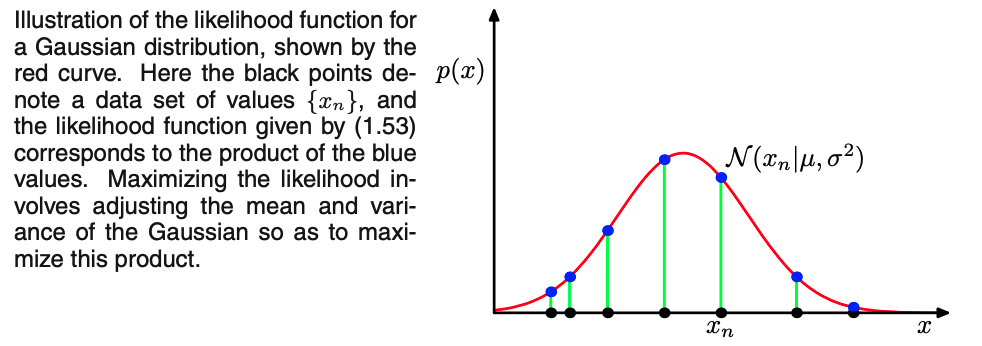

$$ {\color{green} \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^*} = \arg\max L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x})$$

- We can find maximum points by taking the derivative of $~~~\frac{\partial L({\boldsymbol{\mu}, \Sigma};\mbf{x})}{\partial \boldsymbol{\mu}}$ and set it to zero
- We can find maximum points by taking the derivative of $~~~\frac{\partial L({\boldsymbol{\mu}, \Sigma};\mbf{x})}{\partial \boldsymbol{\Sigma}}$ and set it to zero

# Minimizing the Negative Log-Likelihood 

We use `log` because:
- It is a **strictly monotonic function**
- It improves **numerical stability for huge values**
- There is a connection with information theory loss function
- Math will simplify because with `log` and `exp` and $\prod$ will change to $\sum$ because of `log` properties

$$ \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^* = \arg\max L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}) = \arg\max \ln \big( L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}) \big)$$

$$ \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^* = \arg\min \colorbox{yellow}{$-\ln \big( L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}) \big)$}$$

# Minimizing the Negative Log-Likelihood

- Replacing with log works because we need `argmax` not `max`

$$ \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^* = \arg\min \colorbox{yellow}{$-\ln \big( L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}) \big)$} =-\ln \big( \prod_{i=1}^N L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}_i) \big)=-\sum_{i=1}^N\ln L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}_i)$$

# General recipe for optimizing with MLE
## Universal Template

$$  \boldsymbol{\theta}^* = \arg\min_{\boldsymbol{\theta}} -\sum_{i=1}^N\ln \big( L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}_i)\big)$$

<p style="text-align: center;">or</p>

$$  \boldsymbol{\theta}^* = \arg\max_{\boldsymbol{\theta}} \sum_{i=1}^N\ln \big( L(\boldsymbol{\mu}, \boldsymbol{\Sigma};\mbf{x}_i)\big)
$$

# MLE  with a single Gaussian

This holds also for the likelihood:

$$
L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{X}) = \prod_{i=1}^N  \mathcal{N}(\mathbf{x}_i; {\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}})
$$

- We can find ${\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}}$ by **maximizing the likelihood** by doing 

$$ {\color{green} \boldsymbol{\mu}^*, \boldsymbol{\Sigma}^*} = \arg\max L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x}) = \arg\max \ln \big(L({\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}};\mbf{x})\big)$$
 - using **iid assumption**: $$ \arg\max \ln \big(  \prod_{i=1}^N  \mathcal{N}(\mathbf{x}_i; {\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}}) \big)$$

- using log:
    $$ \arg\max \sum_{i=1}^N \ln \big( \mathcal{N}(\mathbf{x}_i; {\color{green} \boldsymbol{\mu}, \boldsymbol{\Sigma}}) \big)$$
    
- and replacing Gaussian equation:

   $$\arg\max \sum_{i=1}^N \ln \left( \frac{1}{(2 \pi)^{D / 2}} \frac{1}{|{\color{green} \boldsymbol{\Sigma}}|^{1 / 2}} \exp \left\{-\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})\right\} \right)$$

- using log property:

$$\arg\max \sum_{i=1}^N \ln \left( \frac{1}{(2 \pi)^{D / 2}} \right)+ \ln \left( \frac{1}{|{\color{green} \boldsymbol{\Sigma}}|^{1 / 2}} \right) + \ln \left( \exp \left\{-\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})\right\} \right)$$

- we can simplify as:
    
    $$\arg\max \sum_{i=1}^N  \text{const} -\frac{1}{2}\ln |{\color{green} \boldsymbol{\Sigma}}| -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})$$

- Now, we can find $\boldsymbol{\mu}$ so that $$~~~\frac{\partial L({\boldsymbol{\mu}, \Sigma};\mbf{x})}{\partial {\color{green} \boldsymbol{\mu}}} = 0$$

$$\frac{\partial}{\partial {\color{green} \boldsymbol{\mu}}} \biggl[ \sum_{i=1}^N ~~\text{const} -\frac{1}{2}\ln |{\color{green} \boldsymbol{\Sigma}}| -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) \biggl] = 0 $$

## Let's write it as a gradient

$$
\nabla_{\bmf{\mu}} \sum_{i=1}^N ~~\text{const} -\frac{1}{2}\ln |{\color{green} \boldsymbol{\Sigma}}| -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) =$$
$$
=\nabla_{\bmf{\mu}} \sum_{i=1}^N -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})
$$

- Change of variable:
- Compute $\nabla_{\mbf{\hat{x}}}\mbf{\hat{x}}^T A\mbf{\hat{x}}$ where $\mbf{\hat{x}} = \mbf{x}-\bmf{\mu}$ and $A=\bmf{\Sigma^{-1}}$
$$
\nabla_{\bmf{\mu}} \sum_{i=1}^N -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})
$$

$$
\nabla_{\mbf{\hat{x}}}\mbf{\hat{x}}^T A\mbf{\hat{x}} =  \underbrace{( A + A^{T} )}_{A = A^{T}} \mbf{\hat{x}} =
2 A \mbf{\hat{x}}
$$

- So it is:

$$
\nabla_{\bmf{\mu}} \sum_{i=1}^N -\frac{1}{2}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}})^{\mathrm{T}}{\color{green} \boldsymbol{\Sigma}^{-1}}({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) = 
$$
$$
= \sum_{i=1}^N -\frac{1}{2} \underbrace{\biggl[ 2 {\color{green} \boldsymbol{\Sigma}^{-1}} ({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) \biggl]}_{2 A \mbf{\hat{x}}}
$$
$$
= -\sum_{i=1}^N  {\color{green} \boldsymbol{\Sigma}^{-1}} ({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) 
$$

- Now we set the gradient equal to 0 :

$$~~~\frac{\partial L({\boldsymbol{\mu}, \Sigma};\mbf{x})}{\partial {\color{green} \boldsymbol{\mu}}} = 0$$
$$
- \sum_{i=1}^N {\color{green} \boldsymbol{\Sigma}^{-1}} ({\color{black}\mathbf{x}_i}-{\color{green}\boldsymbol{\mu}}) = 0
$$
$$
\sum_{i=1}^N {\color{green} \boldsymbol{\Sigma}^{-1}} {\color{black}\mathbf{x}_i} - \underbrace{\sum_{i=1}^N {\color{green} \boldsymbol{\Sigma}^{-1}} {\color{green}\boldsymbol{\mu}}}_{N  {\color{green} \boldsymbol{\Sigma}^{-1}} {\color{green}\boldsymbol{\mu}}} = 0
$$
$$
\cancel{{\color{green} \boldsymbol{\Sigma}^{-1}}} \sum_{i=1}^N  {\color{black}\mathbf{x}_i} = N  {\color{green} \cancel{\boldsymbol{\Sigma}^{-1}}} {\color{green}\boldsymbol{\mu}}
$$
$$
{\color{green}\boldsymbol{\mu}} = \frac{1}{N}\sum_{i=1}^N  {\color{black}\mathbf{x}_i}
$$

## Continue the proof by hand...

# MLE for a single Gaussian

- Input: training data $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$ in d-dimensional space
- Assumption: the underlying generative process is a **single** Gaussian
- MLE (estimate):
- $\bmf{\mu}=\frac{1}{N}\sum_i \mbf{x}_i$
- $\bmf{\Sigma}=\frac{1}{N}\sum_i (\mbf{x}_i-\bmf{\mu})(\mbf{x}_i-\bmf{\mu})^T$

### Remember: MLE gives you an estimate, NOT the underlying distribution

# Let's see a practical example (10 datapoints)
- Assumes we have 10 input data points training data $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$
- **True Gaussian generative process** is $\mathcal{N}(0,1)$

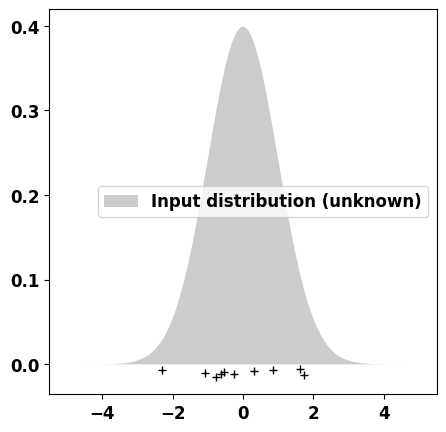

In [26]:
from scipy.stats import norm
np.random.seed(1)
########################################
mu, sigma, N = 0, 1, 10  # mean and standard deviation of the generative process
# when we work in practice we have only points we do not know the generative pocess.
########################################
points = np.random.normal(mu, sigma, N)
X_plot = np.linspace(-5, 5, 1000)

true_dens = norm(mu, sigma).pdf(X_plot)

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="Input distribution (unknown)")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
ax.legend()

In [27]:
def estimate_gaussian_mle(points, X_plot, plot=True):
    # Nowe we estimate with MLE in close form
    mu_mle = points.mean()
    std_mle = np.std(points, ddof=0)
    if plot:
        MLE_dens = norm(mu_mle, std_mle).pdf(X_plot)
        _ = ax.fill(X_plot, MLE_dens, fc="red",
                    alpha=0.2, label="estimated")
    return mu_mle, std_mle


mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

Estimated (-0.09714089080609985, 1.190898552063902) vs Ground-truth (0, 1)


In [28]:
help(np.std)

Help on _ArrayFunctionDispatcher in module numpy:

std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)
    Compute the standard deviation along the specified axis.
    
    Returns the standard deviation, a measure of the spread of a distribution,
    of the array elements. The standard deviation is computed for the
    flattened array by default, otherwise over the specified axis.
    
    Parameters
    ----------
    a : array_like
        Calculate the standard deviation of these values.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the standard deviation is computed. The
        default is to compute the standard deviation of the flattened array.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, a standard deviation is performed over
        multiple axes, instead of a single axis or all the axes as before.
    dtype : dtype, optional
        Type to use in computing the standard

Estimated (-0.09714089080609985, 1.190898552063902) vs Ground-truth (0, 1)


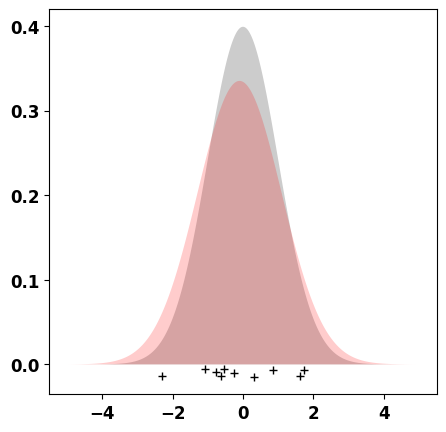

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

# Let's see a practical example (100 datapoints)
- Assumes we have 100 input data points training data $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$
- **True Gaussian generative process** is $\mathcal{N}(0,1)$

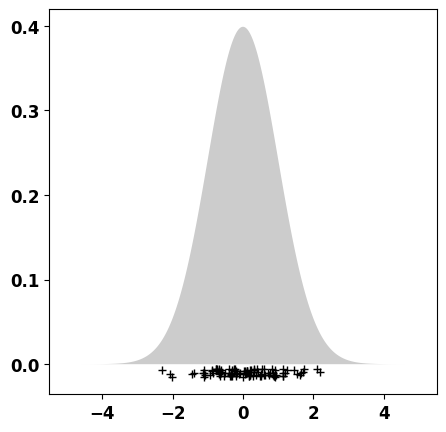

In [30]:
from scipy.stats import norm
np.random.seed(1)
########################################
mu, sigma, N = 0, 1, 100  # mean and standard deviation of the generative process
# when we work in practice we have only points we do not know the generative pocess.
########################################
# when we work in practice we have only points we do not know the generative pocess.
points = np.random.normal(mu, sigma, N)
X_plot = np.linspace(-5, 5, 1000)

true_dens = norm(mu, sigma).pdf(X_plot)

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")

Estimated (0.060582852075698704, 0.885156213831585) vs Ground-truth (0, 1)


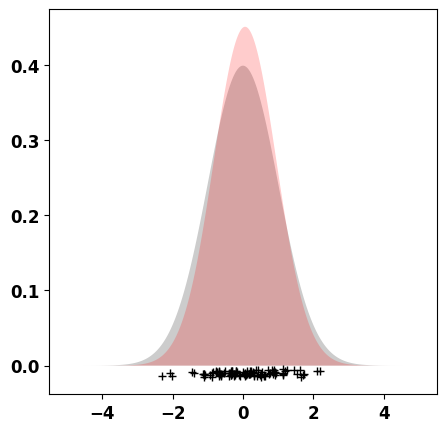

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

## Better than before but the std. deviation is still wrong

# Let's see a practical example (1000 datapoints)
- Assumes we have 1000 input data points training data $X=\{\mbf{x}_1,\ldots,\mbf{x}_N \}$
- **True Gaussian generative process** is $\mathcal{N}(0,1)$

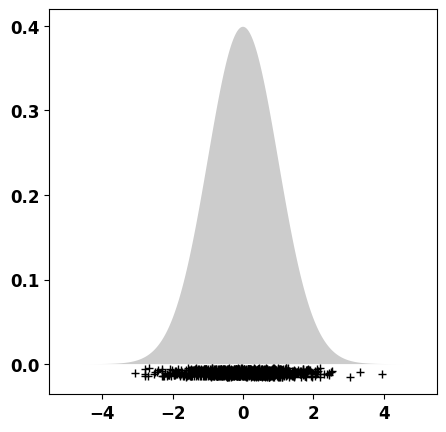

In [32]:
from scipy.stats import norm
np.random.seed(1)
########################################
mu, sigma, N = 0, 1, 1000  # mean and standard deviation of the generative process
# when we work in practice we have only points we do not know the generative pocess.
########################################
# when we work in practice we have only points we do not know the generative pocess.
points = np.random.normal(mu, sigma, N)
X_plot = np.linspace(-5, 5, 1000)

true_dens = norm(mu, sigma).pdf(X_plot)

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")

Estimated (0.03881247615960185, 0.9810041339322116) vs Ground-truth (0, 1)


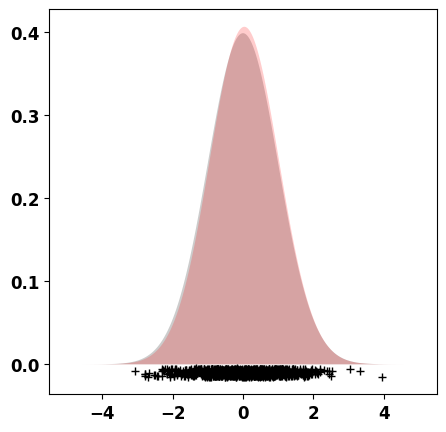

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

## With 1000 training points seems to be OK

# But what about different shapes?

# MLE tends to underestimate the deviation of the Gaussian

<img width="70%" src="figs/MLE_std_biased.png" />

# MLE single Gaussian wrap up

## MLE performs density estimation

By estimating the parameters of an unknown distribution given data, we get an estimate of the density of the data.
This can be useful for:
- predicting the probability that a new, unseen data is coming from the same generative process.
- This means that by estimating the density, you can test how **"anomalous" is an unseen datapoint** (assuming your estimate is a good one). It can be used in **Anomaly Detection** applications.
- Given that you have a density, you can also use the parametric model **to generate new data** from the density.

# Problem: What if the data is generated by a multi-modal distribution?

- For example: you are modeling the background for a video-surveillance application, and you have assumed that the background more or less behave in a **single mode** during the whole day **plus some minor variations**.
    - For example the background is always *black-ish with some minor variations of "black" given by less or more light.*
- You then decide to estimate the parameters **for each pixel** of a single Gaussian using MLE, given a training set of background videos.
- At test-time, you can estimate how probable is a new pixel to be part of the background or foreground by simply estimating the probability of this new pixel to be part of your MLE estimate for that pixel.

- By inspecting better the data, you realize that the single mode assumption is **NOT** correct.
- at 3pm the background is black-ish but then suddenly in the data you have a tree that continuous moves the leaves so that those will be also part of the background
- Your single mode program will detect each time the leaves as false alarm and the video-surveillance app wont' work well.

# What can we do now?

# We will cover it in the next lectured (We can "mix" multiple Gaussians)

## Mixture of Gaussian will be also our last lecture about unsupervised learning 👋🏼